# Recurrent Neural Net (RNN) w/Series Expression

---
#### Note on the data set 
The data set used here is not particularly complex and/or big. It's not really all that challenging to find the fraud. In an ideal world we'd be using more complex data sets to show the real power of Deep Learning. There are a bunch of PCA'ed data sets available, but the PCA obfuscates some of the elements that are useful. 
*These examples are meant to show the possibilities, it's not so useful to interpret their performance on this data set*

In [1]:
import torch
import numpy as np
import pandas as pd
import datetime as dt
import gc

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define base feature and read the File
The base features are features found in the input file. They need to be defined after which the file can be read using the `EnginePandasNumpy`. Using the `from_csv` method.

A new function had been adeed to calculate the time-delta between consequent payments for the same customer. It's input will be a Panda's DataFrame and it will output a normalized (to 190 days) time-delta. Remember that __normalizing__ the data is important for Neural Nets, it allows them to converge much faster.

The new function is used in the `FeatureExpressionSeries` feature named __'date-time-delta'__.

In [3]:
# Change this to read from another location
file = '../../../../data/bs140513_032310.csv'

In [4]:
step = ft.FeatureSource('step', ft.FEATURE_TYPE_INT_16) 
customer = ft.FeatureSource('customer', ft.FEATURE_TYPE_STRING)
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

base_features = ft.TensorDefinition(
    'base', 
    [
        step,
        customer,
        age,
        gender,
        merchant,
        category,
        amount,
        fraud
    ])

# Function to calculate the date and time from the step
def step_to_date(step_count: int):
    return dt.datetime(2020, 1, 1) + dt.timedelta(days=int(step_count))

# Function to calculate the time difference between all rows and normalise
def calc_delta(dates):
    if isinstance(dates, pd.DataFrame):
        res = dates.diff() / np.timedelta64(190, 'D')
        res = res.fillna(0).abs()
        return res
    else:
        # There was only 1 row
        return 0

date_time = ft.FeatureExpression('date', ft.FEATURE_TYPE_DATE_TIME, step_to_date, [step])
date_time_delta = ft.FeatureExpressionSeries('delta', ft.FEATURE_TYPE_FLOAT_32, calc_delta, [date_time])

intermediate_features = ft.TensorDefinition(
    'intermediate', 
    [
        customer,
        step,
        age,
        gender,
        merchant,
        category,
        amount,
        fraud
    ])

age_i = ft.FeatureIndex('age_index', ft.FEATURE_TYPE_INT_8, age)
gender_i = ft.FeatureIndex('gender_index', ft.FEATURE_TYPE_INT_8, gender)
merchant_i = ft.FeatureIndex('merchant_index', ft.FEATURE_TYPE_INT_16, merchant)
category_i = ft.FeatureIndex('category_index', ft.FEATURE_TYPE_INT_16, category)
amount_scale = ft.FeatureNormalizeScale('amount_scale', ft.FEATURE_TYPE_FLOAT_32, amount)
fraud_label = ft.FeatureLabelBinary('fraud_label', fraud)

cust_learn_features = ft.TensorDefinition(
    'customer_learning', 
    [
        age_i,
        gender_i,
    ])

trx_learn_features = ft.TensorDefinition(
    'transaction_learning', 
    [
        customer,
        date_time,
        merchant_i,
        category_i,
        amount_scale,
        date_time_delta,
        fraud_label
    ])

multi_head_td = ft.TensorDefinitionMulti([cust_learn_features, trx_learn_features])

with en.EnginePandasNumpy(num_threads=8) as e:
    df = e.from_csv(base_features, file, inference=False)
    df = e.from_df(intermediate_features, df, inference=False)
    cust_df = e.from_df(cust_learn_features, df, inference=False)
    trx_df  = e.from_df(trx_learn_features, df, inference=False)
    cust_list = e.to_numpy_list(cust_learn_features, cust_df)
    series_list = e.to_series_stacked(trx_df, trx_learn_features, key_field=customer, time_field=date_time, length=5)

print('Customer data Shapes')
print(cust_list.shapes)
print(cust_list.dtype_names)
print('Series Shapes')
print(series_list.shapes)
print(series_list.dtype_names)

data_list = en.NumpyList(cust_list.lists + series_list.lists)
print('Numpy Shapes')
print(data_list.shapes)    

2020-12-03 13:00:07.960 d373c7.engines.common          INFO     Start Engine...
2020-12-03 13:00:07.960 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2020-12-03 13:00:07.960 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2020-12-03 13:00:07.961 d373c7.engines.panda_numpy     INFO     Building Panda for : base from file ../../../../data/bs140513_032310.csv
2020-12-03 13:00:08.201 d373c7.engines.panda_numpy     INFO     Building Panda for : <base> from DataFrame. Inference mode <False>
2020-12-03 13:00:08.218 d373c7.engines.panda_numpy     INFO     Done creating base. Shape=(594643, 8)
2020-12-03 13:00:08.219 d373c7.engines.panda_numpy     INFO     Building Panda for : <intermediate> from DataFrame. Inference mode <False>
2020-12-03 13:00:08.231 d373c7.engines.panda_numpy     INFO     Done creating intermediate. Shape=(594643, 8)
2020-12-03 13:00:08.232 d373c7.engines.panda_numpy     INFO     Building Panda for : <customer_learning> from DataFrame. Infere

Customer data Shapes
[(594643, 2)]
['int8']
Series Shapes
[(594643, 5, 2), (594643, 5, 2), (594643, 1)]
['float32', 'int16', 'int8']
Numpy Shapes
[(594643, 2), (594643, 5, 2), (594643, 5, 2), (594643, 1)]


## Wrangle the data
Time to split the data. For time series data it is very important to keep the order of the data. Below split will start from the end and work it's way to the front of the data. Doing so the training, validation and test data are nicely colocated in time. You almost *never* want to plain shuffle time based data.

> 1. Split out a test-set of size `test_records`. This is used for model testing.
> 2. Split out a validation-set of size `validation_records`. It will be used to monitor overfitting during training
> 3. All the rest is considered training data.

For time-series we'll perform an additional action.
> 1. The series at the beginning of the data set will all be more or less empty as there is no history, that is not so useful during training, ideally we have records with history and complete series, sometimes named 'mature' series. We'll throw away the first couple of entries.

__Important__; please make sure the data is ordered in ascending fashion on a date(time) field. The split function does not order the data, it assumes the data is in the correct order.

In [5]:
test_records = 100000
val_records  = 30000 
maturation   = 30000

train_data, val_data, test_data = data_list.split_time(val_records, test_records) 
train_data = train_data[maturation:]

print(f'Training Data shapes {train_data.shapes}')
print(f'Validation Data shapes {val_data.shapes}')
print(f'Test Data shapes {test_data.shapes}')
del data_list
gc.collect()
print('Done')

Training Data shapes [(434643, 2), (434643, 5, 2), (434643, 5, 2), (434643, 1)]
Validation Data shapes [(30000, 2), (30000, 5, 2), (30000, 5, 2), (30000, 1)]
Test Data shapes [(100000, 2), (100000, 5, 2), (100000, 5, 2), (100000, 1)]
Done


## Set-up Devices

In [6]:
device, cpu = pt.init_devices()

2020-12-03 13:00:17.451 d373c7.pytorch.common          INFO     Torch Version : 1.7.0
2020-12-03 13:00:17.479 d373c7.pytorch.common          INFO     GPU found. Using GPU <0>
2020-12-03 13:00:17.480 d373c7.pytorch.common          INFO     Cuda Version  : 10.2


In [7]:
# Setup Pytorch Datasets for the training and validation
batch_size = 128
train_ds = pt.NumpyListDataSetMulti(multi_head_td, train_data)
val_ds = pt.NumpyListDataSetMulti(multi_head_td, val_data)
train_sampler = pt.ClassSamplerMulti(multi_head_td, train_data).over_sampler()

# Wrap them in a Pytorch Dataloader
train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2, sampler=train_sampler)
val_dl = val_ds.data_loader(cpu, batch_size, num_workers=2)

# Create a Model
m = pm.ConvolutionalFraudClassifierMulti(
    multi_head_td, conv_layers=[(12, 2, 1), (24, 2, 1)], linear_layers=[8]
)
print(m)

ConvolutionalFraudClassifierMulti(
  Number of parameters : 3864
  (head): TensorDefinitionHeadMulti(
    Embedded TDs=['customer_learning', 'transaction_learning']
    (heads): ModuleList(
      (0): TensorDefinitionHead(
        lcs=['Categorical']
        (embedding): Embedding(
          (embeddings): ModuleList(
            (0): Embedding(9, 4)
            (1): Embedding(5, 4)
          )
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
      (1): TensorDefinitionHead(
        lcs=['Continuous', 'Categorical']
        (embedding): Embedding(
          (embeddings): ModuleList(
            (0): Embedding(51, 25)
            (1): Embedding(16, 7)
          )
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
  )
  (body): BodyMulti(
    (layers): ModuleList(
      (0): None
      (1): ConvolutionalBody1d(
        (conv_layers): Sequential(
          (conv_01): Conv1d(34, 12, kernel_size=(2,), stride=(1,))
          (relu_01): ReLU(inplace=

## Start Training

### First find a decent Learning Rate. 
> Create a trainer and run the find_lr function and plot. This functions iterates over the batches gradually increasing the learning rate from a minimum to a maximum learning rate.

2020-12-03 13:00:23.001 d373c7.pytorch.training        INFO     Saving model under ./temp_model.pt
Finding LR in 200 steps: 100%|██████████| 200/200 [00:01<00:00, 195.27it/s]
2020-12-03 13:00:25.630 d373c7.pytorch.training        INFO     Restoring model from ./temp_model.pt


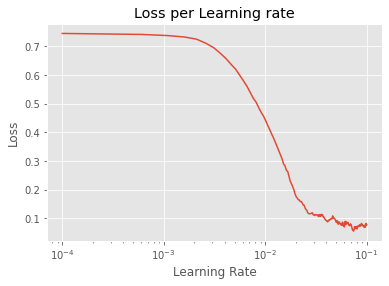

In [8]:
t = pt.Trainer(m, device, train_dl, val_dl)
r = t.find_lr(1e-4, 1e-1, 200)
pl.TrainPlot().plot_lr(r)

### Start Training and plot the results
> We train for __10 epochs__ and __learning rate 5e-3__. That means we run over the total training data set a total of 10 times/epochs where the model learns, after each epoch we use the trained model and perform a test run on the validation set.

Epoch 010/010: 100%|██████████| 3631/3631 [00:15<00:00, 229.73it/s, train_loss=0.0288, train_acc=0.991, val_loss=0.0173, val_acc=0.994]


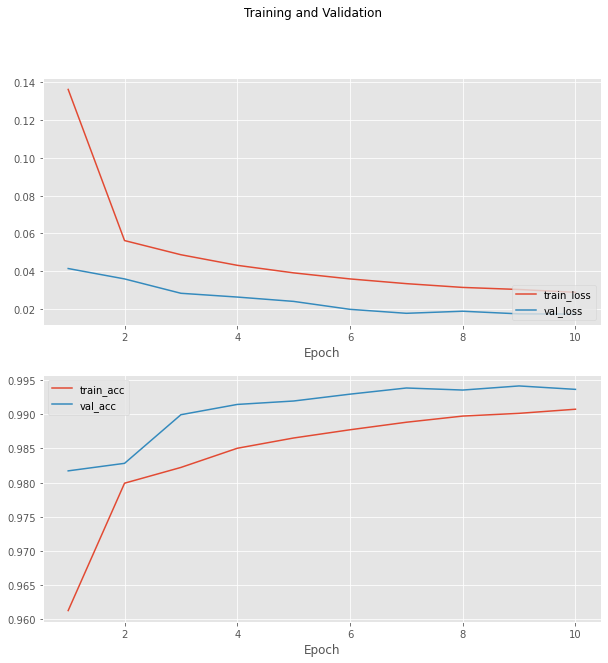

In [9]:
t = pt.Trainer(m, device, train_dl, val_dl)
h = t.train_one_cycle(10, 5e-3)
pl.TrainPlot().plot_history(h, fig_size=(10,10))

## Test the model on the test data

> Test the model on the test set, it is data that was not seen during training and allows us to validate model results. 

Testing in 782 steps: 100%|██████████| 782/782 [00:01<00:00, 479.93it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     98926
         1.0       0.68      0.98      0.80      1074

    accuracy                           0.99    100000
   macro avg       0.84      0.99      0.90    100000
weighted avg       1.00      0.99      1.00    100000


auc score : 0.9979
ap score  : 0.9687
-----------------------------------------------------


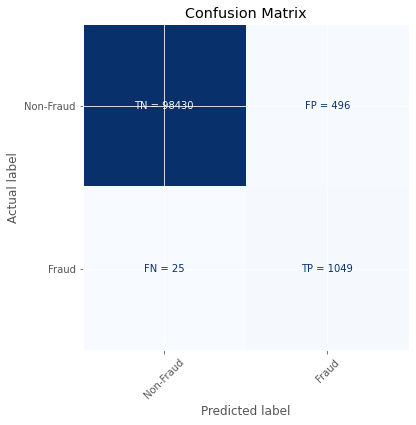

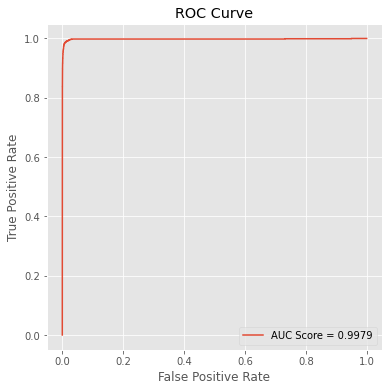

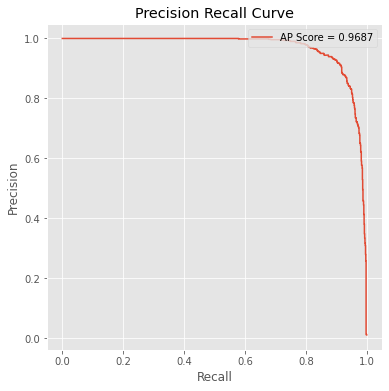

In [10]:
test_ds = pt.NumpyListDataSetMulti(multi_head_td, test_data)
test_dl = test_ds.data_loader(cpu, 128, num_workers=2)

ts = pt.Tester(m, device, test_dl)
pr = ts.test_plot()
tp = pl.TestPlot()
tp.print_classification_report(pr)
tp.plot_confusion_matrix(pr, fig_size=(6,6))
tp.plot_roc_curve(pr, fig_size=(6,6))
tp.plot_precision_recall_curve(pr, fig_size=(6,6))

## Plot Embeddings
> As we have embeddings in this model, we can visualize them. Interesting enough we get again get a lot variance in the first component and the es_leisure sticks out again.

In [1]:
w = m.embedding_weights(category_i, True)
pl.LayerPlot().plot_embedding(category_i, w, dims=3, fig_size=(10,10))

NameError: name 'm' is not defined